# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from schemas import DataCatalog
import constants as const
import seaborn as sns

### **Loading the catalog**

In [2]:
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [3]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

#Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [18]:
combined_df['APPT_MODE'].unique()

array(['Face-to-Face', 'Home Visit', 'Telephone', 'Video/Online',
       'Unknown'], dtype=object)

#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [4]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [19]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

#Replacing months values to FY- years
combined_df_copy['APPOINTMENT_MONTH'] = combined_df_copy['APPOINTMENT_MONTH'].replace({'APR2021':'FY2021', 'MAY2021':'FY2021', 'JUN2021':'FY2021', 'JUL2021':'FY2021', 'AUG2021':'FY2021', 'SEP2021':'FY2021',
                                                                                       'OCT2021':'FY2021', 'NOV2021':'FY2021', 'DEC2021':'FY2021', 'JAN2022':'FY2021', 'FEB2022':'FY2021', 'MAR2022':'FY2021',
                                                                                       'APR2022':'FY2022', 'MAY2022':'FY2022', 'JUN2022':'FY2022', 'JUL2022':'FY2022', 'AUG2022':'FY2022', 'SEP2022':'FY2022',
                                                                                       'OCT2022':'FY2022', 'NOV2022':'FY2022', 'DEC2022':'FY2022', 'JAN2023':'FY2022', 'FEB2023':'FY2022', 'MAR2023':'FY2022',
                                                                                       'APR2023':'FY2023', 'MAY2023':'FY2023', 'JUN2023':'FY2023', 'JUL2023':'FY2023', 'AUG2023':'FY2023'})

combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021'].rename(columns={'APPOINTMENT_MONTH':'FY_YEAR'})
combined_df_copy['FY_YEAR'].unique()

array(['FY2021', 'FY2022', 'FY2023'], dtype=object)

### **Creating separate DF's for attended and not attended appointments**

In [20]:
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
attended_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021               6441.2406
                                                   FY2022               6409.7105
                                                   FY2023               5193.6111
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               6031.7656
                                                   FY2022               6074.6977

In [22]:
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] != 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
do_not_attend_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021                327.0419
                                                   FY2022                294.0753
                                                   FY2023                281.0080
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                280.9590
                                                   FY2022                311.2077

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [8]:
National_average_attended = attended_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_attended_2022 = attended_df.loc[slice(None),'FY2022',:].mean().round(4)

SNEE_average_attended = attended_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'The national average for attended appointments for FY2021-22-23 is: {National_average_attended}')
print(f'The SNEE average for attended appointments for FY2021-22-23 is: {SNEE_average_attended.mean()}')
print(f'The national average for attended appointments for FY2022 is: {National_average_attended_2022}')

SNEE_average_attended

The national average for attended appointments for FY2021-22-23 is: 4414.3347
The SNEE average for attended appointments for FY2021-22-23 is: COUNT_OF_APPOINTMENTS    2067.6403
dtype: float64
The national average for attended appointments for FY2022 is: COUNT_OF_APPOINTMENTS    4763.7655
dtype: float64


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,2187.6634
FY2022,2178.0886
FY2023,1837.1689


#### **2. Not attended or unknown Appointments**

In [9]:
National_average_DNA = do_not_attend_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_DNA_2022 = do_not_attend_df.loc[slice(None),'FY2022',:].mean().round(4)

SNEE_average_DNA = do_not_attend_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'The National average for did not attend or unknown appointments for FY2021-22-23 is: {National_average_DNA}')
print(f'The SNEE average for did not attend or unknown appointments for FY2021-22-23 is: {SNEE_average_DNA.mean()}')
print(f'The National average for did not attend or unknown appointments for FY2022 is: {National_average_DNA_2022}')

SNEE_average_DNA

The National average for did not attend or unknown appointments for FY2021-22-23 is: 259.9349
The SNEE average for did not attend or unknown appointments for FY2021-22-23 is: COUNT_OF_APPOINTMENTS    100.102
dtype: float64
The National average for did not attend or unknown appointments for FY2022 is: COUNT_OF_APPOINTMENTS    277.7867
dtype: float64


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,97.5304
FY2022,101.0678
FY2023,101.7078


- We can see that the overall average for non-attended appointments for SNEE-ICB is 100, which is much lesser than National Average of 260
  
- For year 2022, this difference increases as the National average increases from 260 to 277, whereas for SNEE-ICB the change is from 100 to 101

### **Plotting the attended and non-attended lineplot**

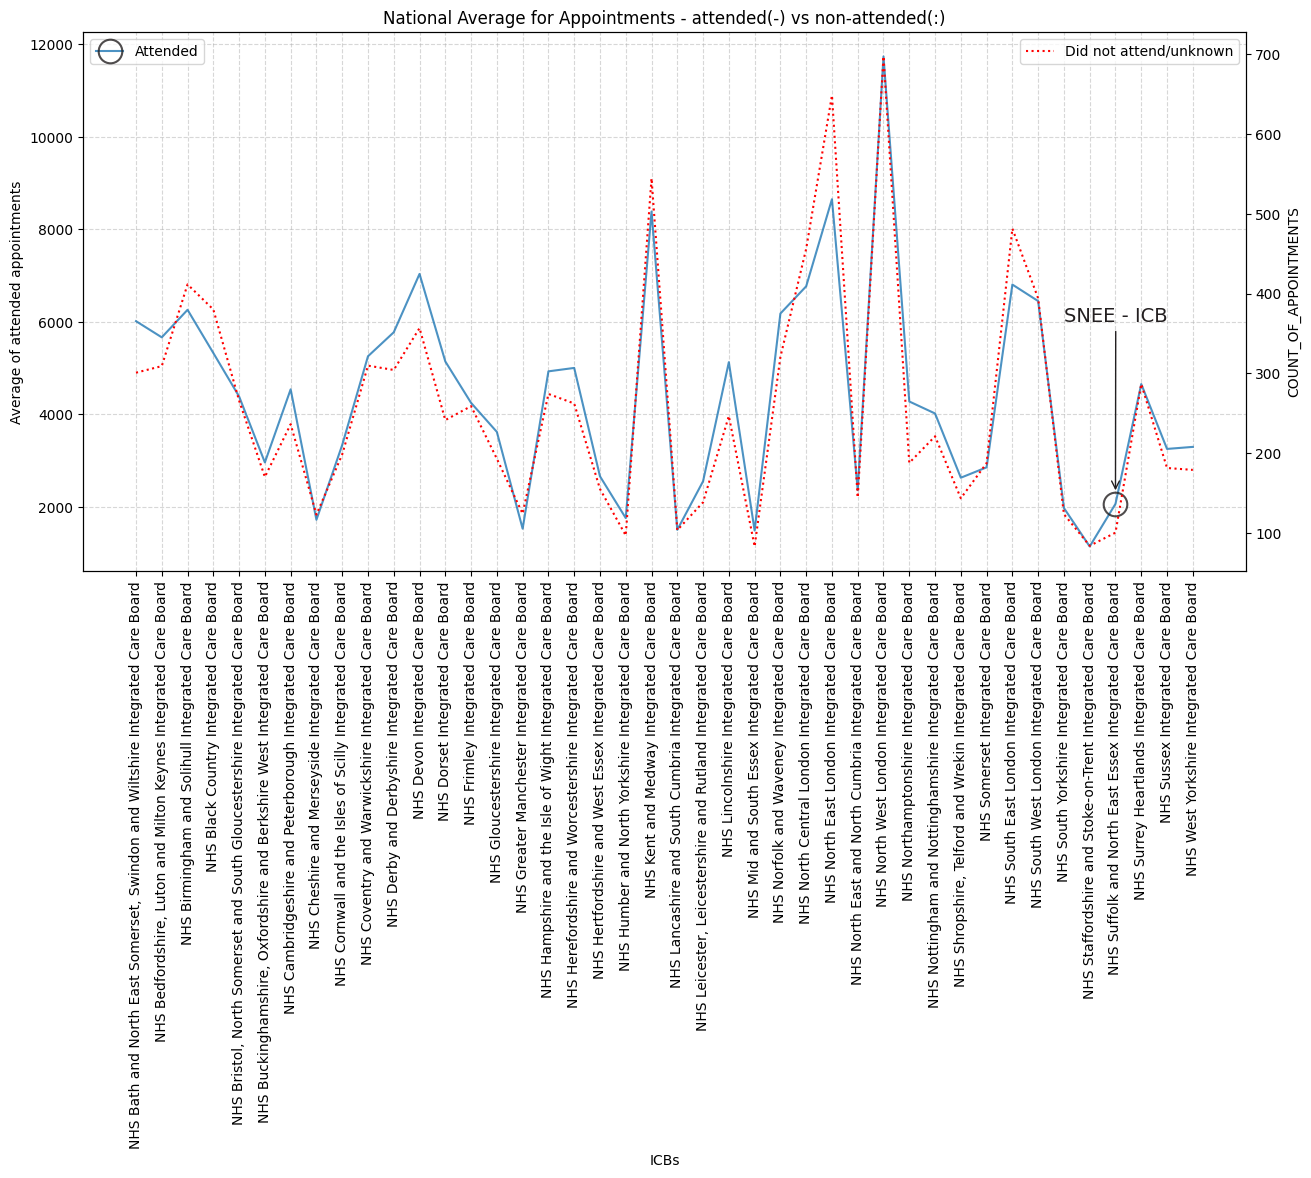

In [10]:
attended_df2 = attended_df.groupby('ICB_NAME').mean().reset_index()
do_not_attend_df2 = do_not_attend_df.groupby('ICB_NAME').mean().reset_index()

snee = 'NHS Suffolk and North East Essex Integrated Care Board'
#Plotting the lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(38,2300), xytext=(36,6000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')
#Creating secondary y-axis
ax2 = ax.twinx()
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df2, color ='red', linestyle=':', ax=ax2, label = 'Did not attend/unknown')
ax2.set_label('Average of did not attend Appointments')

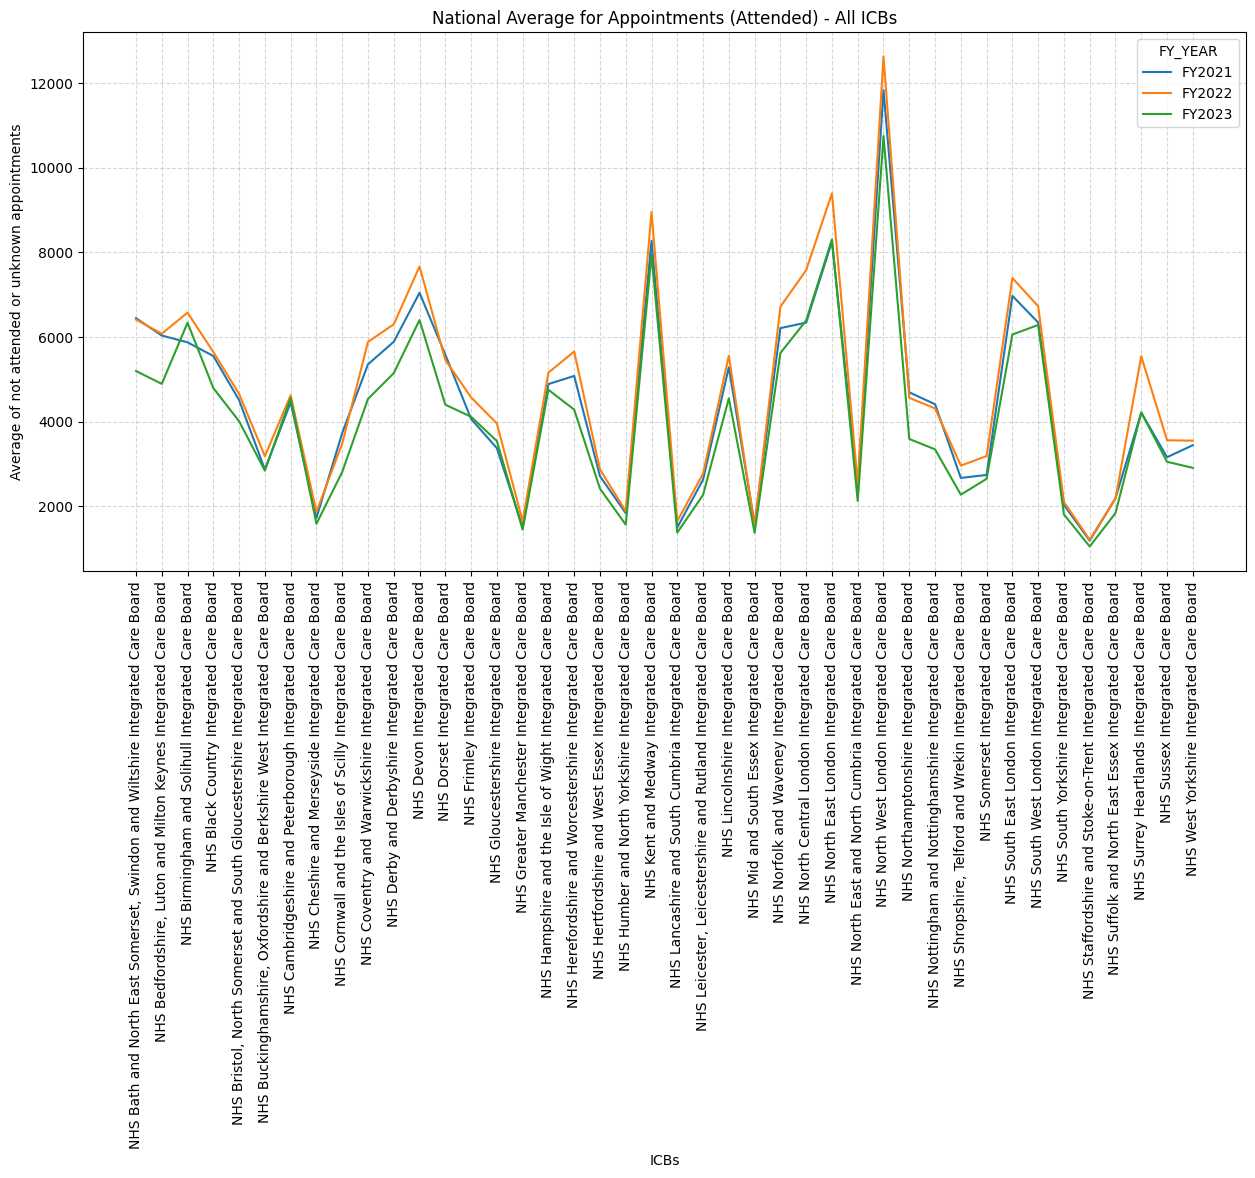

In [11]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

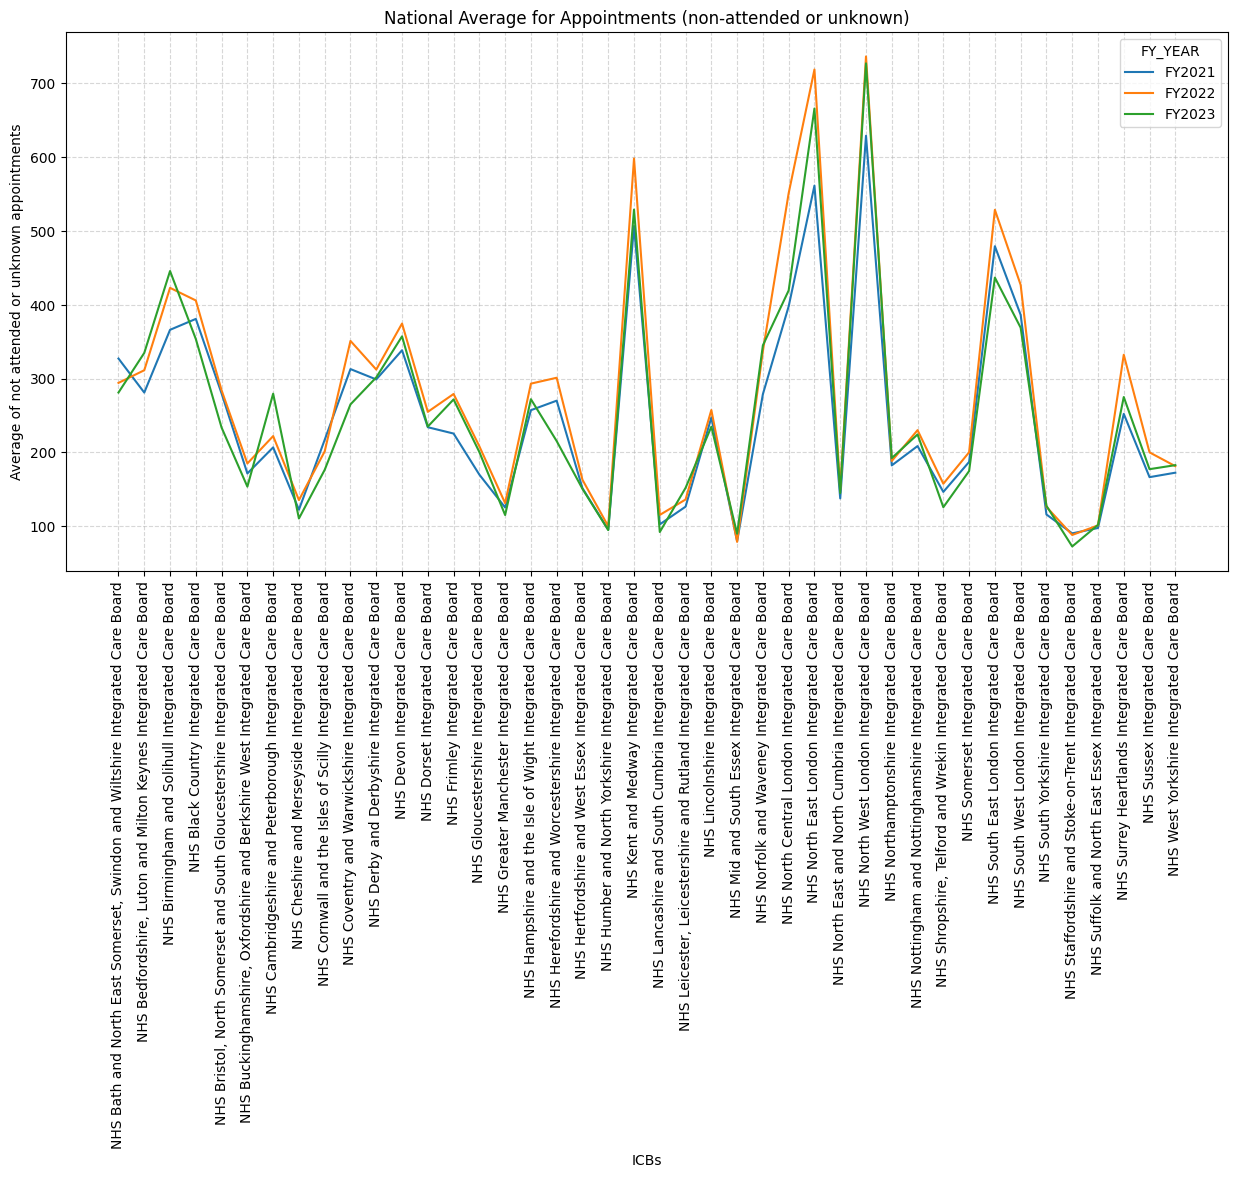

In [12]:
#Plotting the did not attended or unknown lineplpots
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021               6441.2406
                                                   FY2022               6409.7105
                                                   FY2023               5193.6111
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               6031.7656
                                                   FY2022               6074.6977
...                                                                           ...
NHS Sussex Integrated Care Board                   FY2022               3557.7694
                                                   FY2023               3048.7516
NHS West Yorkshire Integrated Care Board           FY2021               3441.3841
                                                   FY2022               3547.8527
                                                   FY2023               2906.2496

[126 rows x 1 columns]

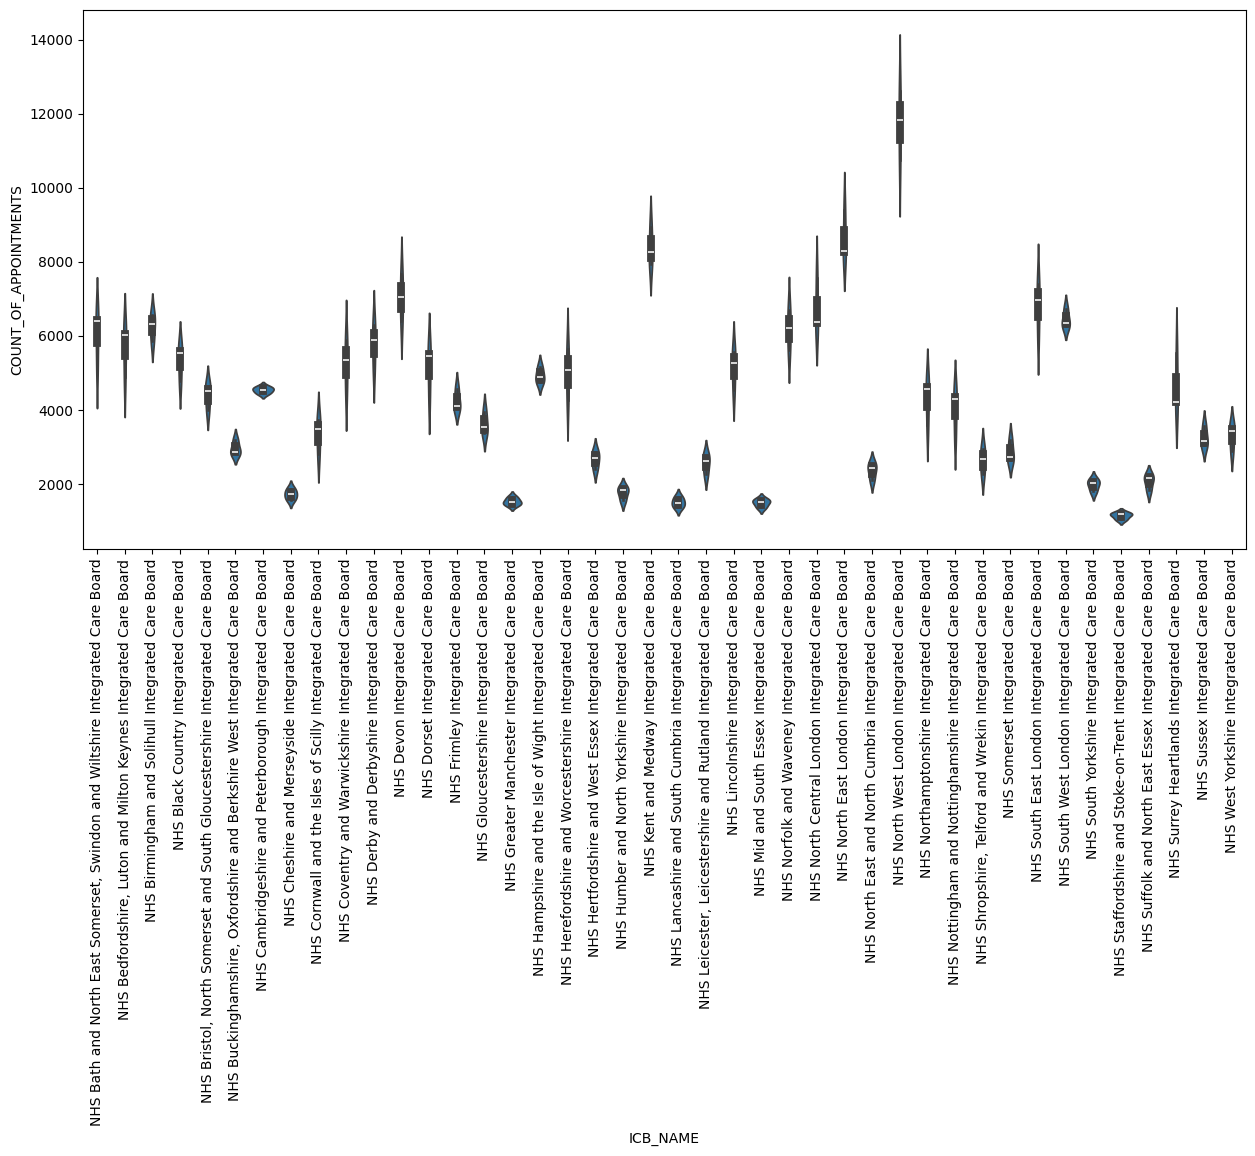

In [16]:
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.violinplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df)
attended_df

### **Analysing the effect of HCP type and Appointment mode**

In [23]:
combined_df_copy

,ICB_NAME,SUB_ICB_LOCATION_ONS_CODE,FY_YEAR,APPT_STATUS,HCP_TYPE,APPT_MODE,COUNT_OF_APPOINTMENTS
140,NHS West Yorkshire Integrated Care Board,E38000025,FY2021,Attended,GP,Face-to-Face,1598
141,NHS West Yorkshire Integrated Care Board,E38000025,FY2021,Attended,GP,Face-to-Face,405
142,NHS West Yorkshire Integrated Care Board,E38000025,FY2021,Attended,GP,Face-to-Face,3372
143,NHS West Yorkshire Integrated Care Board,E38000025,FY2021,Attended,GP,Face-to-Face,187
144,NHS West Yorkshire Integrated Care Board,E38000025,FY2021,Attended,GP,Face-to-Face,1215
...,...,...,...,...,...,...,...
5583,"NHS Bath and North East Somerset, Swindon and ...",E38000231,FY2023,Unknown,Unknown,Unknown,202
5584,"NHS Bath and North East Somerset, Swindon and ...",E38000231,FY2023,Unknown,Unknown,Unknown,153
5585,"NHS Bath and North East Somerset, Swindon and ...",E38000231,FY2023,Unknown,Unknown,Unknown,237
5586,"NHS Bath and North East Somerset, Swindon and ...",E38000231,FY2023,Unknown,Unknown,Unknown,40


In [36]:
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             14436.9871
                                                            Home Visit                 142.7819
                                                            Telephone                11148.2478
                                                            Unknown                     23.3611
                                                            Video/Online               102.5330
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                66.9141
                                                            Home Visit                  19.0409
                                                            Telephone                  342.0952
                                                            Unknown                    915.0151
                                                            Video/Online                28.3333

[600 rows x 1 columns]

In [35]:
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] != 'Attended'].drop(columns=['SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face               400.4009
                                                            Home Visit                   3.5130
                                                            Telephone                  110.4186
                                                            Unknown                     22.2632
                                                            Video/Online                 4.0056
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                15.5203
                                                            Home Visit                   7.4491
                                                            Telephone                    9.7985
                                                            Unknown                     54.2481
                                                            Video/Online                11.0000

[605 rows x 1 columns]

In [65]:
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,481.1398,1189.0332,45.5460
Home visit,23.5635,20.9361,17.4643
Telephone,262.1513,188.4992,29.4066
Unknown,33.5371,68.0858,99.9015
Video/Online,22.1635,22.6973,15.5319


<Axes: >

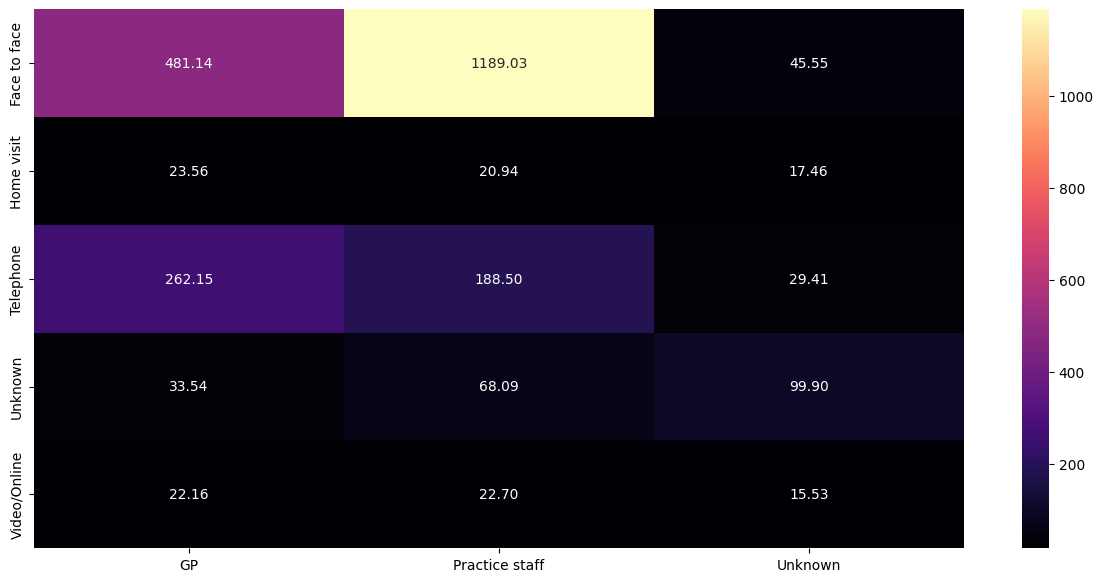

In [76]:
plt.subplots(figsize=(15,7))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='magma')

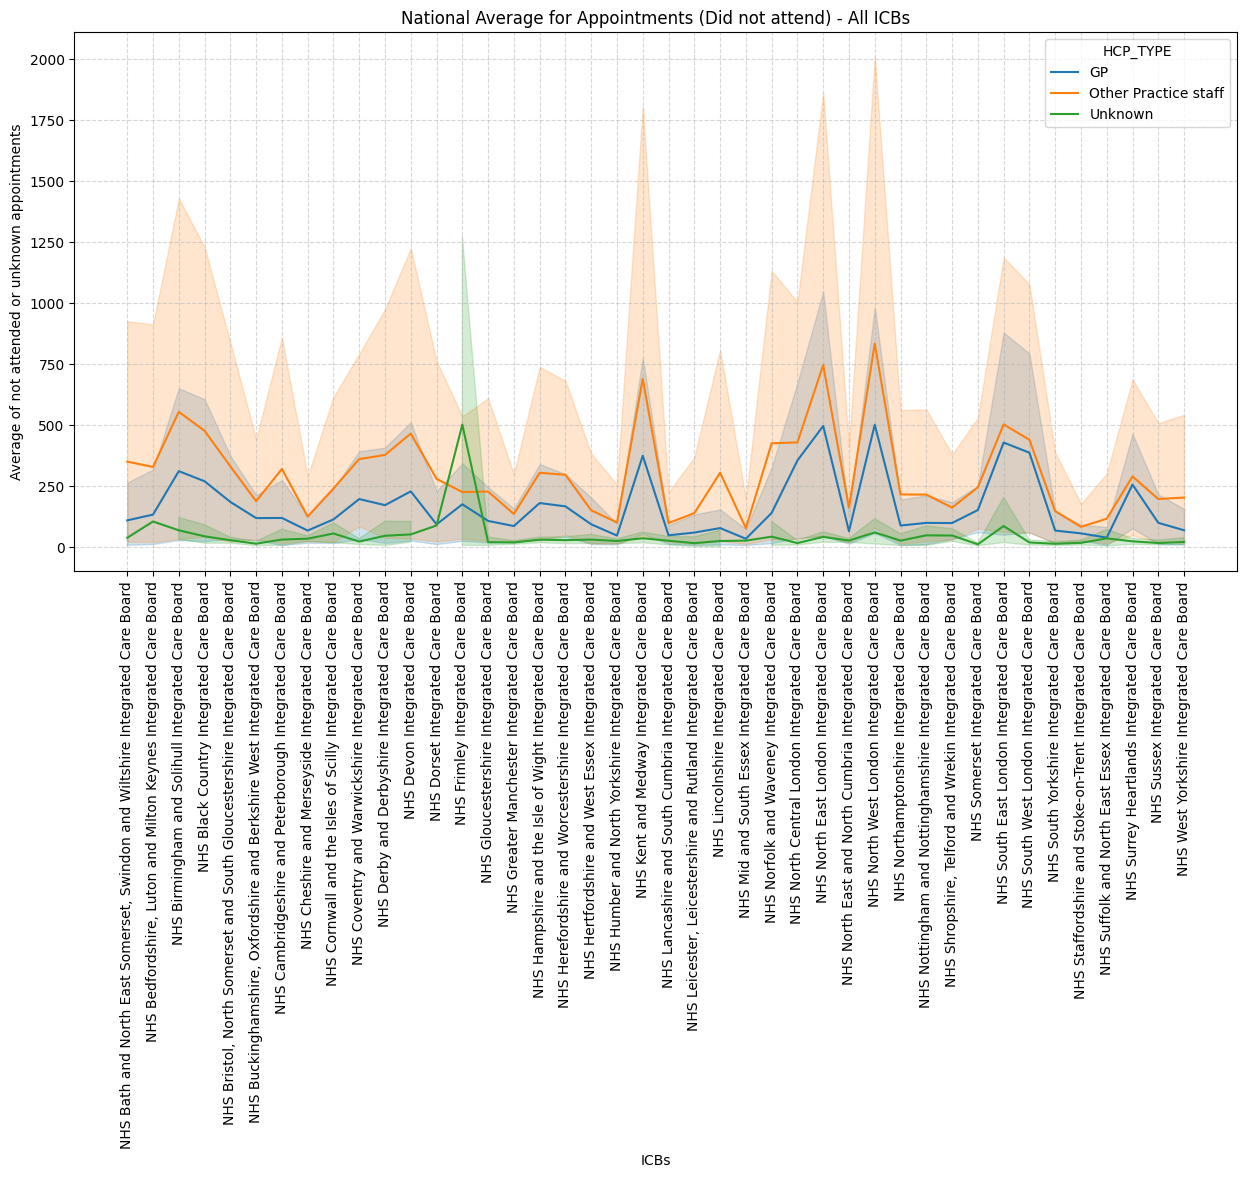

In [57]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Did not attend) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

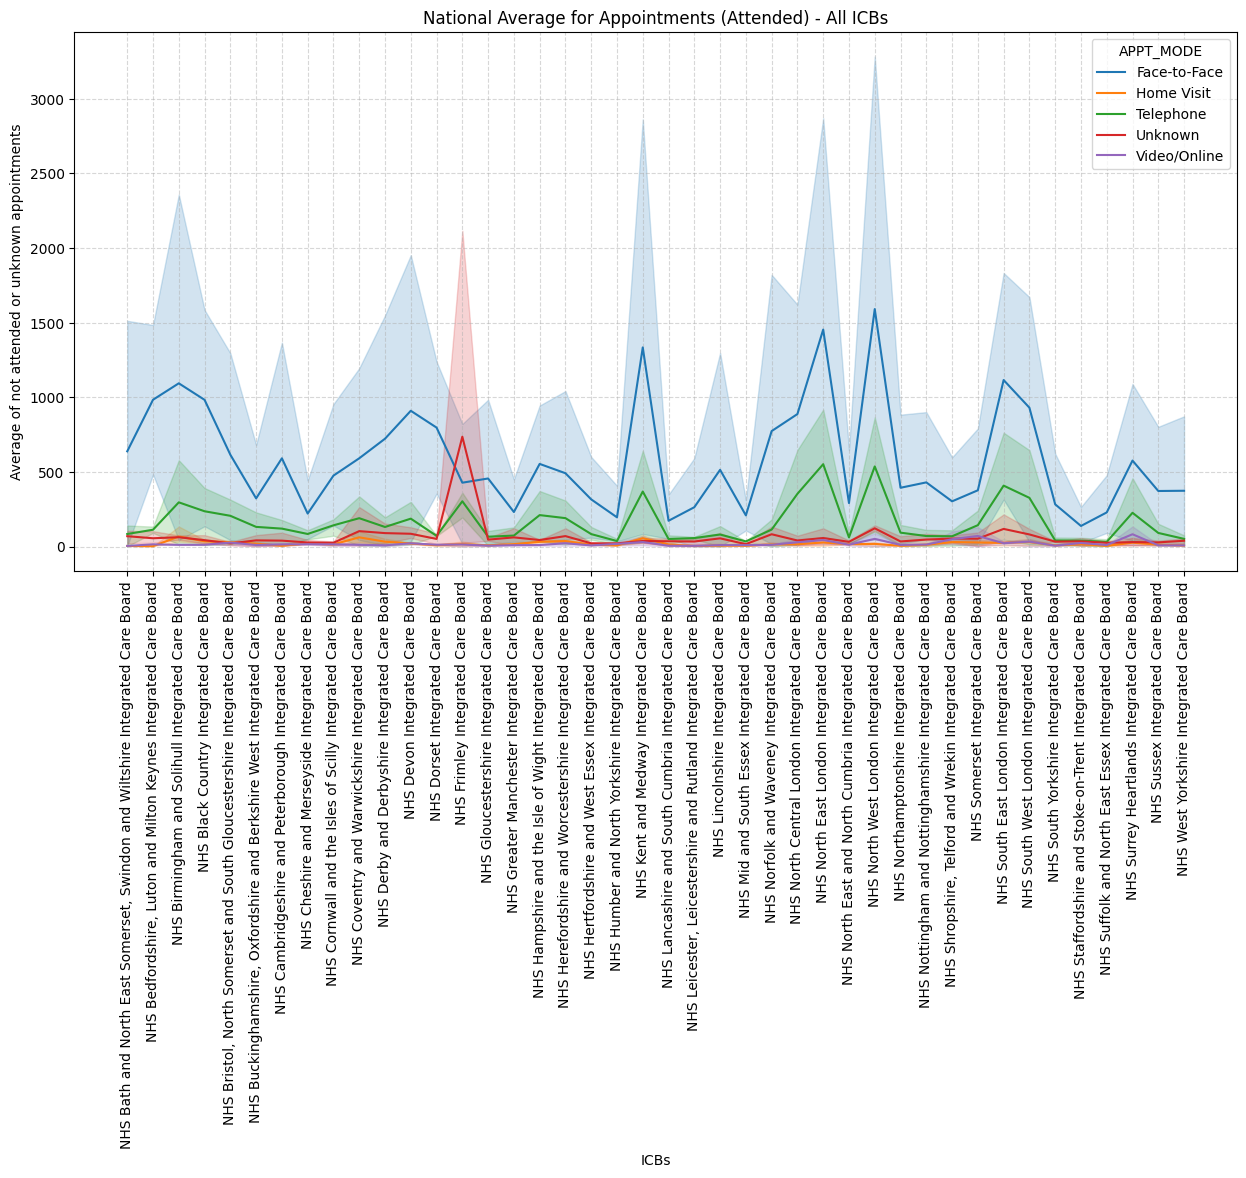

In [53]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

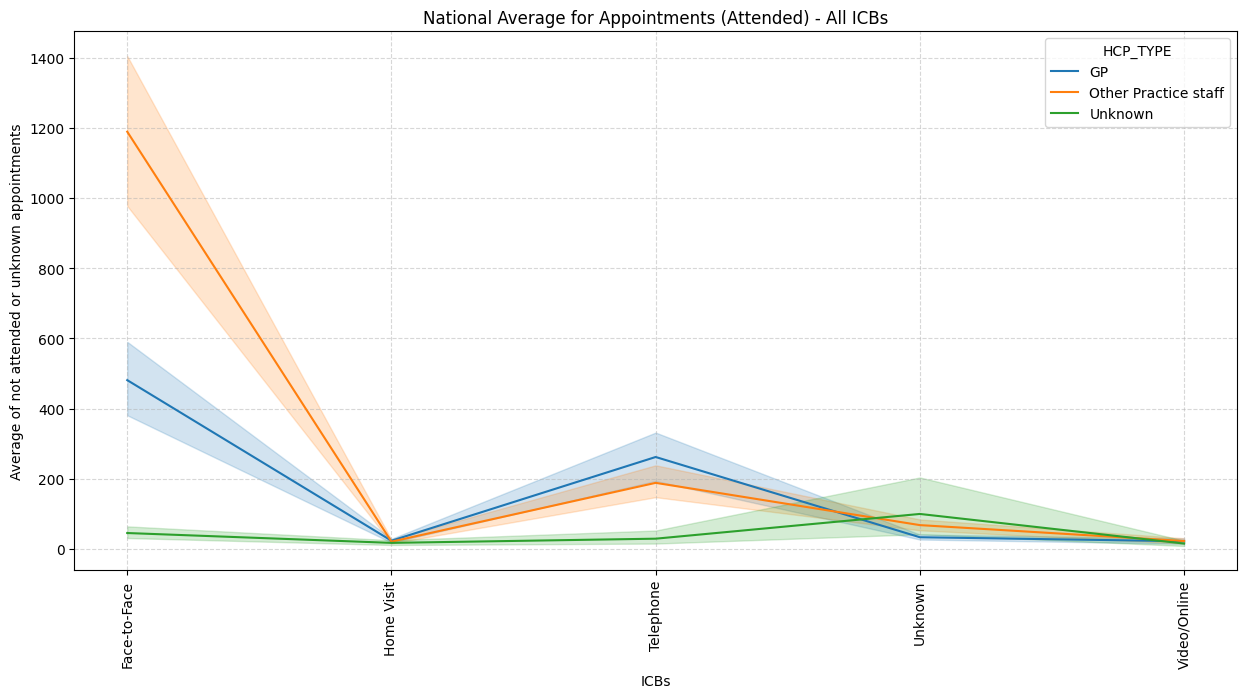

In [55]:
#Plotting the Attended appointments lineplot
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.lineplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended or unknown appointments')
plt.title('National Average for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)